# Wine quality prediction

# Imports

In [1]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(level='INFO')

mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

In [2]:
import hopsworks
import pandas as pd
import missingno as msno

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Project setup

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) prometheus
	 (2) liuyunlu

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/194714
Connected. Call `.close()` to terminate connection gracefully.


## Load data

In [108]:
# fetch dataset 
dataset_path = '../dataset/wine/wine.csv'
with open(dataset_path, 'r') as f:
    wine_df = pd.read_csv(f)
wine_df.columns = wine_df.columns.str.replace(' ', '_')
wine_df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [109]:
wine_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6487 non-null   float64
 2   volatile_acidity      6489 non-null   float64
 3   citric_acid           6494 non-null   float64
 4   residual_sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [110]:
wine_df['type'] = wine_df['type'].map({'red': 0, 'white': 1})

In [111]:
wine_df.describe()


,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,0.753886,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,0.430779,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,1.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,1.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,1.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [133]:
# Drop the type column as it is not relevant for the analysis
#wine_df = wine_df.drop([ 'type'], axis=1)
wine_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              6497 non-null   int64  
 1   volatile_acidity  6497 non-null   float64
 2   chlorides         6497 non-null   float64
 3   density           6497 non-null   float64
 4   alcohol           6497 non-null   float64
 5   quality           6497 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 304.7 KB


In [113]:
# change the quality column to binary values 0 and 1 every value above 5 is good (1) and every value below 5 is bad (0)
wine_df['quality'] = wine_df['quality'].apply(lambda x: 1 if x > 5 else 0)


In [114]:
# Count occurrences of 0s and 1s in the quality
counts = wine_df['quality'].value_counts()

# Print the counts
print(counts)


quality
1    4113
0    2384
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)


### Missing data

<Axes: >

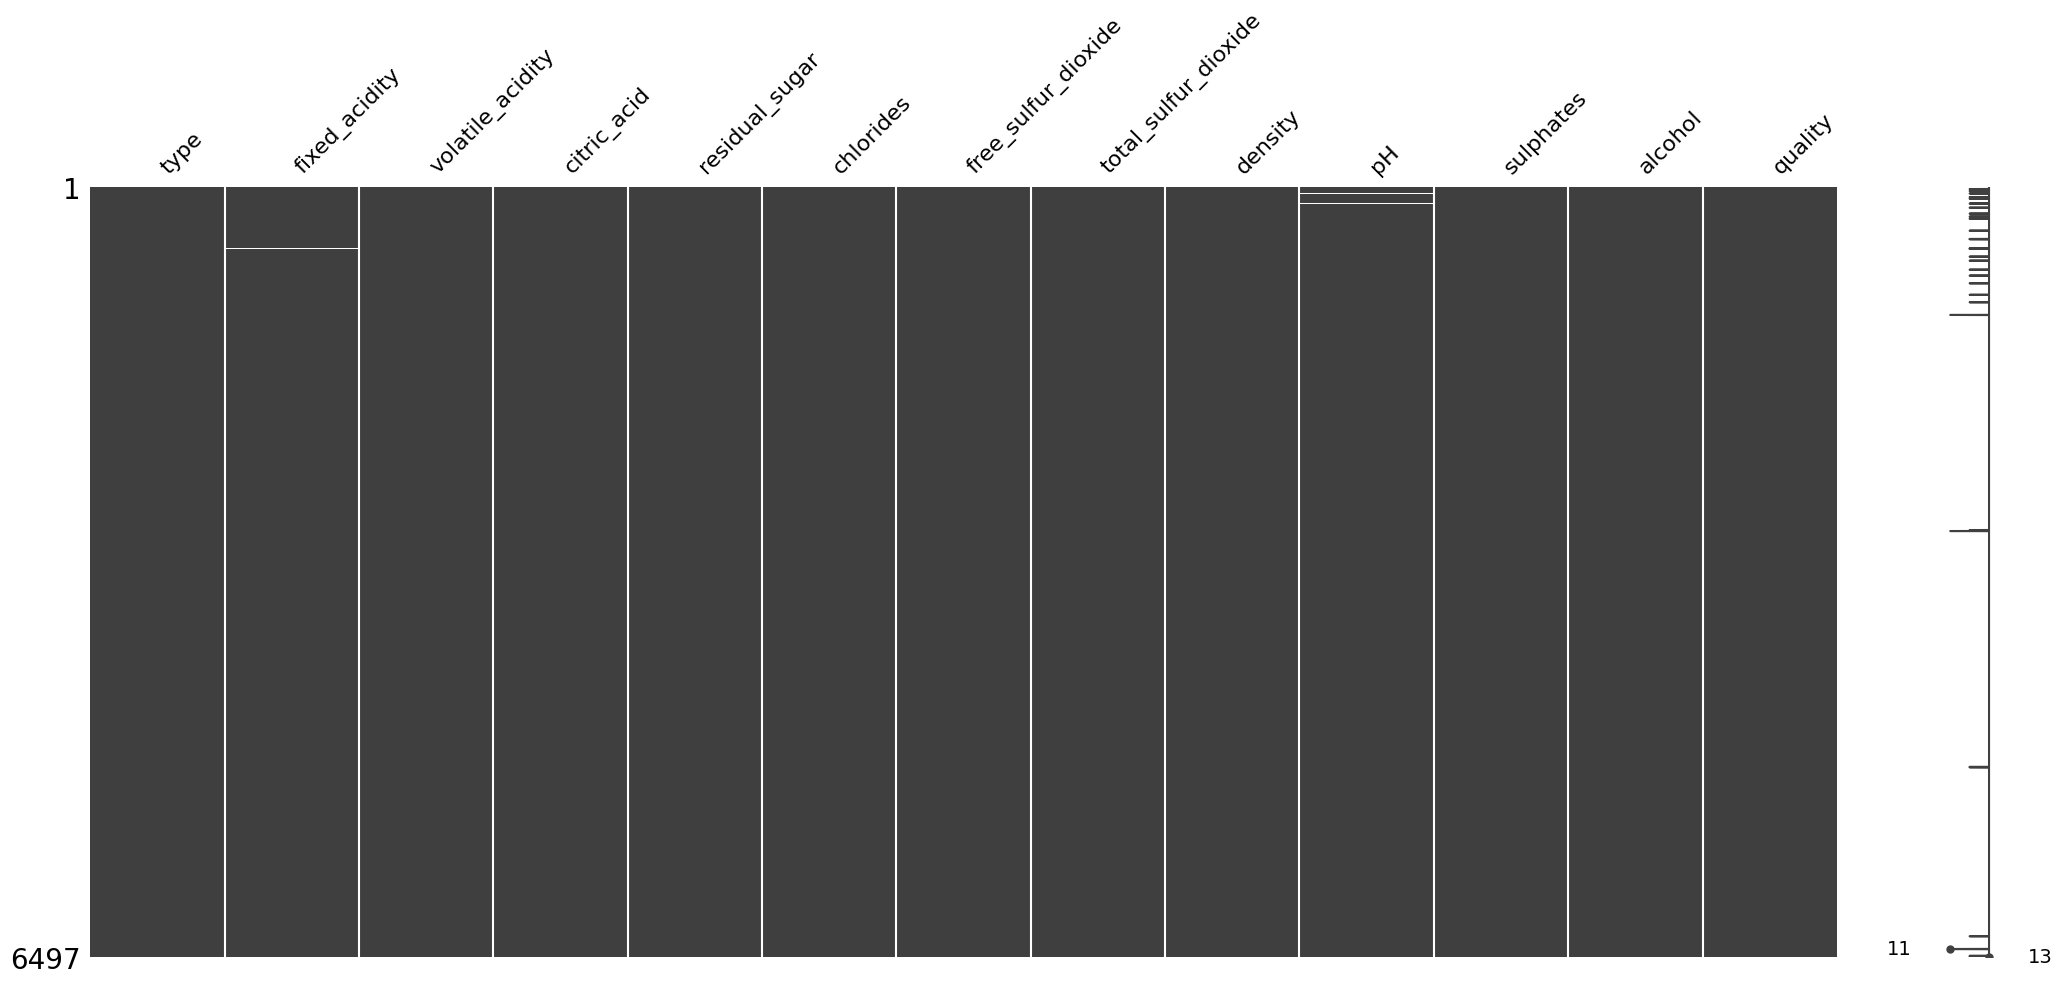

In [115]:
msno.matrix(wine_df)

In [116]:
# get each of the missing vlaue indexes for each column
missing_value_indexes = {}
for col in wine_df.columns:
    missing_value_indexes[col] = wine_df[wine_df[col].isnull()].index.tolist()
print('indexes of missing values:')
missing_value_indexes

indexes of missing values:


{'type': [],
 'fixed_acidity': [17, 174, 249, 267, 368, 518, 1079, 2902, 6428, 6429],
 'volatile_acidity': [86, 521, 621, 812, 1079, 2894, 4895, 6486],
 'citric_acid': [268, 909, 6320],
 'residual_sugar': [33, 438],
 'chlorides': [98, 747],
 'free_sulfur_dioxide': [],
 'total_sulfur_dioxide': [],
 'density': [],
 'pH': [54, 139, 440, 587, 697, 972, 4892, 6428, 6429],
 'sulphates': [224, 2902, 6321, 6493],
 'alcohol': [],
 'quality': []}

In [117]:
import numpy as np

# Replace missing values with a random value from a normal distribution with mean and std
# Can also use mean for the imputation seems more common when searching online
for col in wine_df.columns:
    mean_val = wine_df[col].mean()
    std_val = wine_df[col].std()
    missing_indexes = wine_df[wine_df[col].isnull()].index.tolist()
    for index in missing_indexes:
        wine_df.loc[index, col] = np.random.normal(mean_val, std_val)

In [118]:
# get each of the missing vlaue indexes for each column
missing_value_indexes = {}
for col in wine_df.columns:
    missing_value_indexes[col] = wine_df[wine_df[col].isnull()].index.tolist()
print('indexes of missing values:')
missing_value_indexes

indexes of missing values:


{'type': [],
 'fixed_acidity': [],
 'volatile_acidity': [],
 'citric_acid': [],
 'residual_sugar': [],
 'chlorides': [],
 'free_sulfur_dioxide': [],
 'total_sulfur_dioxide': [],
 'density': [],
 'pH': [],
 'sulphates': [],
 'alcohol': [],
 'quality': []}

### Univariate analysis

array([[<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'fixed_acidity'}>,
        <Axes: title={'center': 'volatile_acidity'}>,
        <Axes: title={'center': 'citric_acid'}>],
       [<Axes: title={'center': 'residual_sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free_sulfur_dioxide'}>,
        <Axes: title={'center': 'total_sulfur_dioxide'}>],
       [<Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>],
       [<Axes: title={'center': 'quality'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

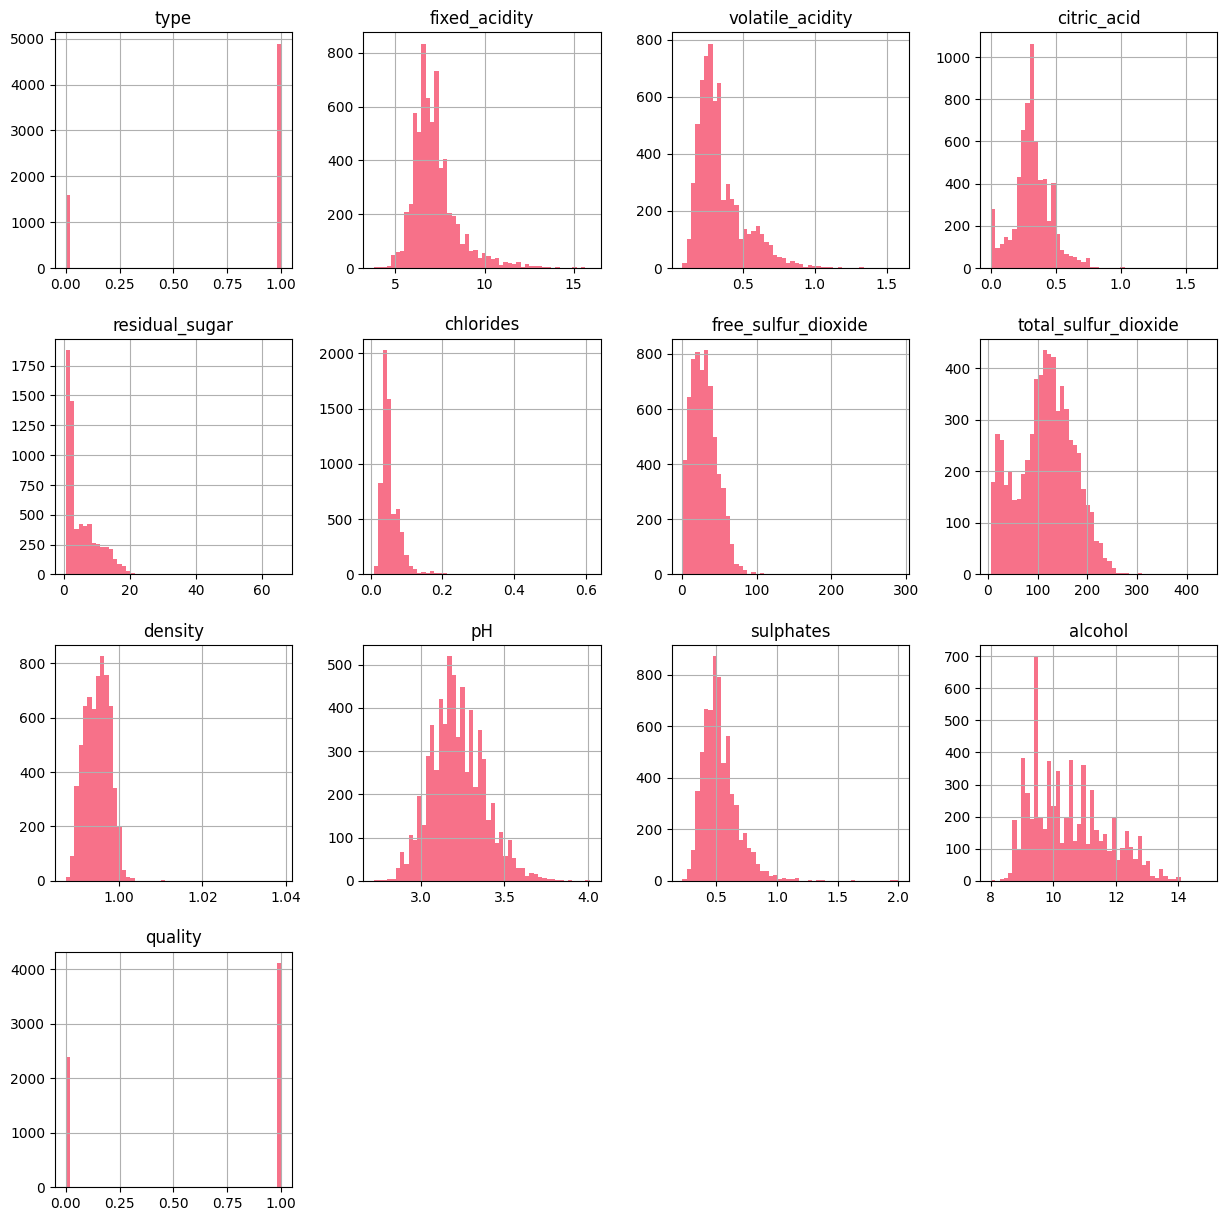

In [119]:
wine_df.hist(figsize=(15, 15), bins=50)

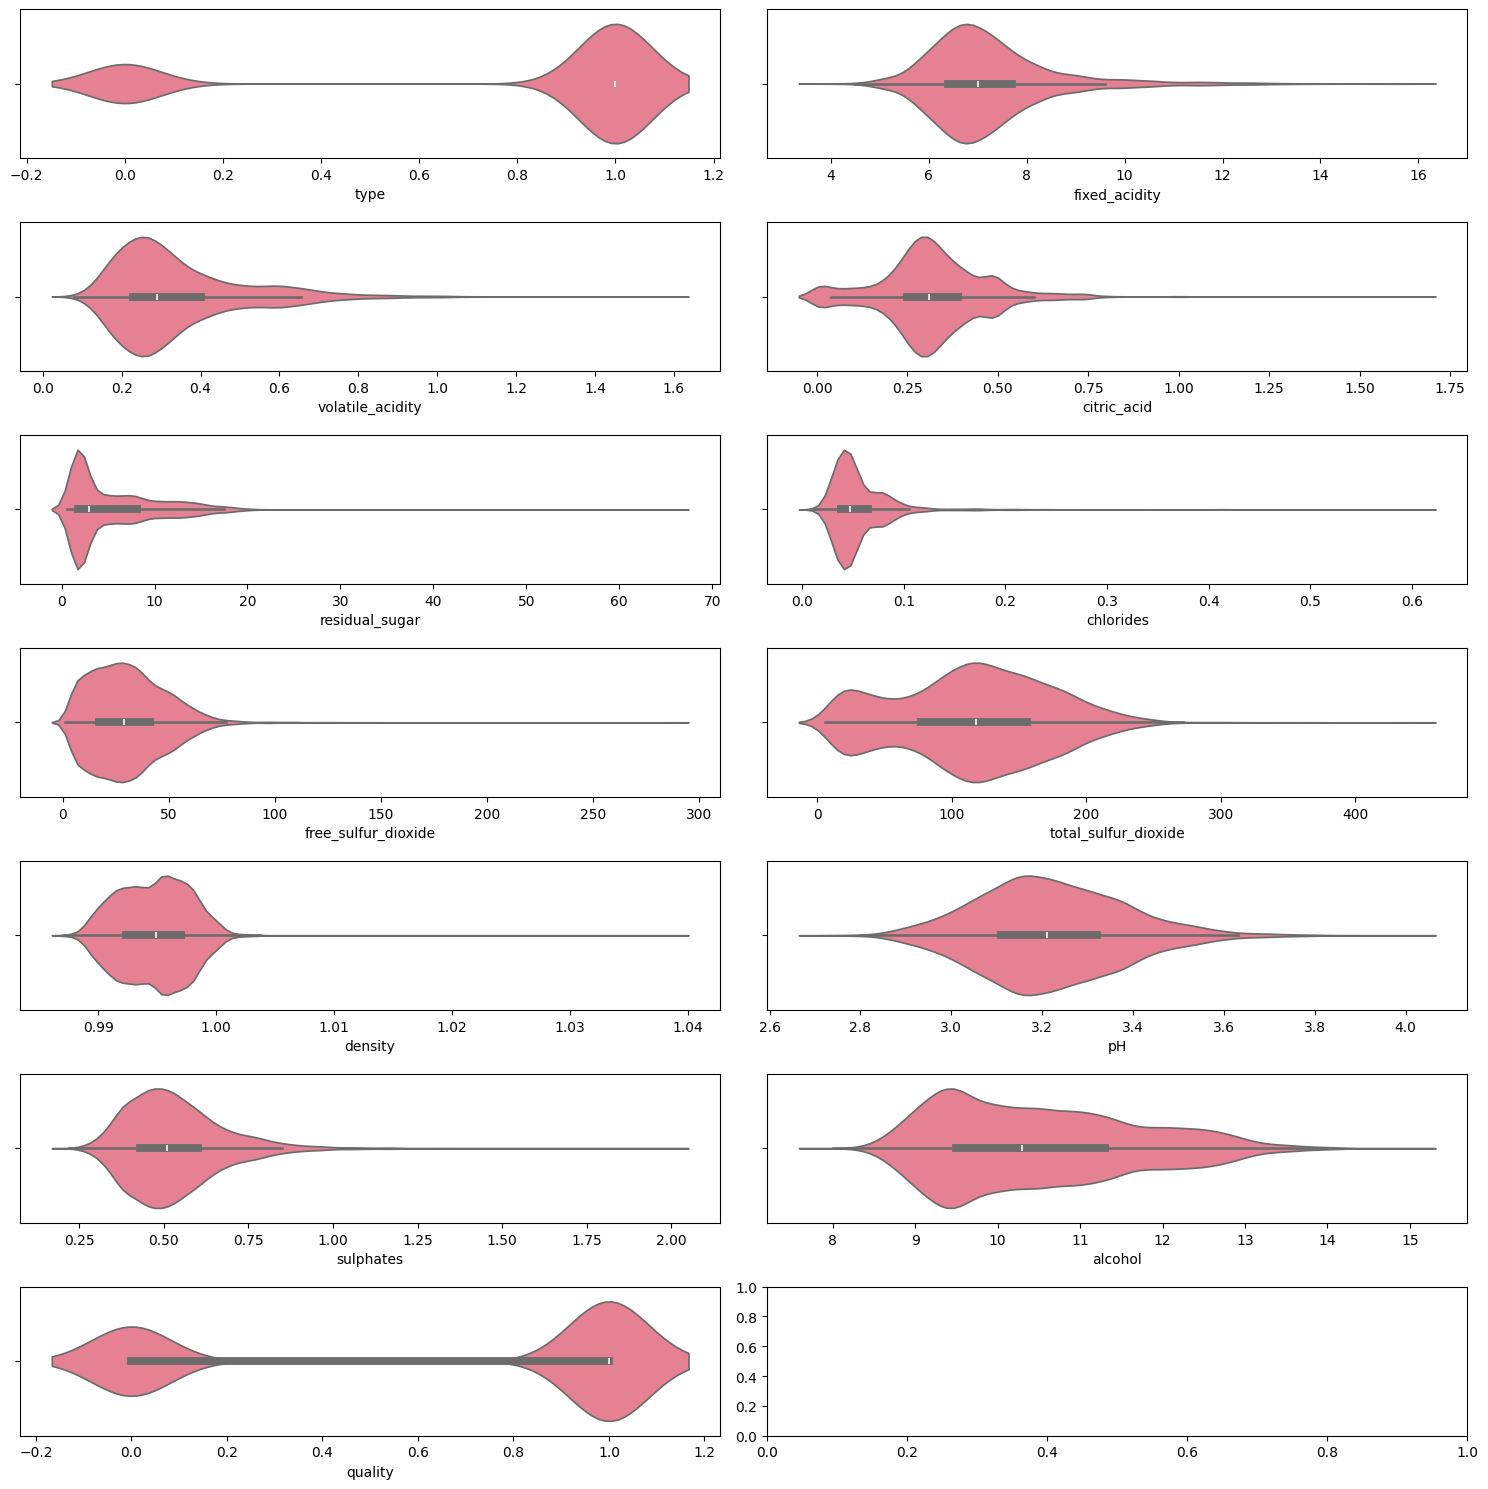

In [121]:
# violin plots using seaborn for the range of values for each feature in seperate plots
fig, axes = plt.subplots(7, 2, figsize=(15, 15))

axes = axes.flatten()
for i, col in enumerate(wine_df.columns):
    sns.violinplot(x=col, data=wine_df, ax=axes[i])

plt.tight_layout()
plt.show()


### Bivariate analysis

0
1


2
3
4
5
6
7
8
9
10
11
[('alcohol_0', [8.0, 14.9]), ('alcohol_1', [8.4, 14.2]), ('chlorides_0', [0.009, 0.611]), ('chlorides_1', [0.012, 0.415]), ('citric_acid_0', [0.0, 1.0]), ('citric_acid_1', [0.0, 1.66]), ('density_0', [0.98722, 1.00315]), ('density_1', [0.98711, 1.03898]), ('fixed_acidity_0', [4.2, 15.9]), ('fixed_acidity_1', [3.8, 15.6]), ('free_sulfur_dioxide_0', [2.0, 289.0]), ('free_sulfur_dioxide_1', [1.0, 112.0]), ('pH_0', [2.74, 3.9]), ('pH_1', [2.72, 4.01]), ('residual_sugar_0', [0.6, 23.5]), ('residual_sugar_1', [0.7, 65.8]), ('sulphates_0', [0.25, 2.0]), ('sulphates_1', [0.22, 1.95]), ('total_sulfur_dioxide_0', [6.0, 440.0]), ('total_sulfur_dioxide_1', [6.0, 294.0]), ('type_0', [0, 1]), ('type_1', [0, 1]), ('volatile_acidity_0', [0.1, 1.58]), ('volatile_acidity_1', [0.08, 1.04])]


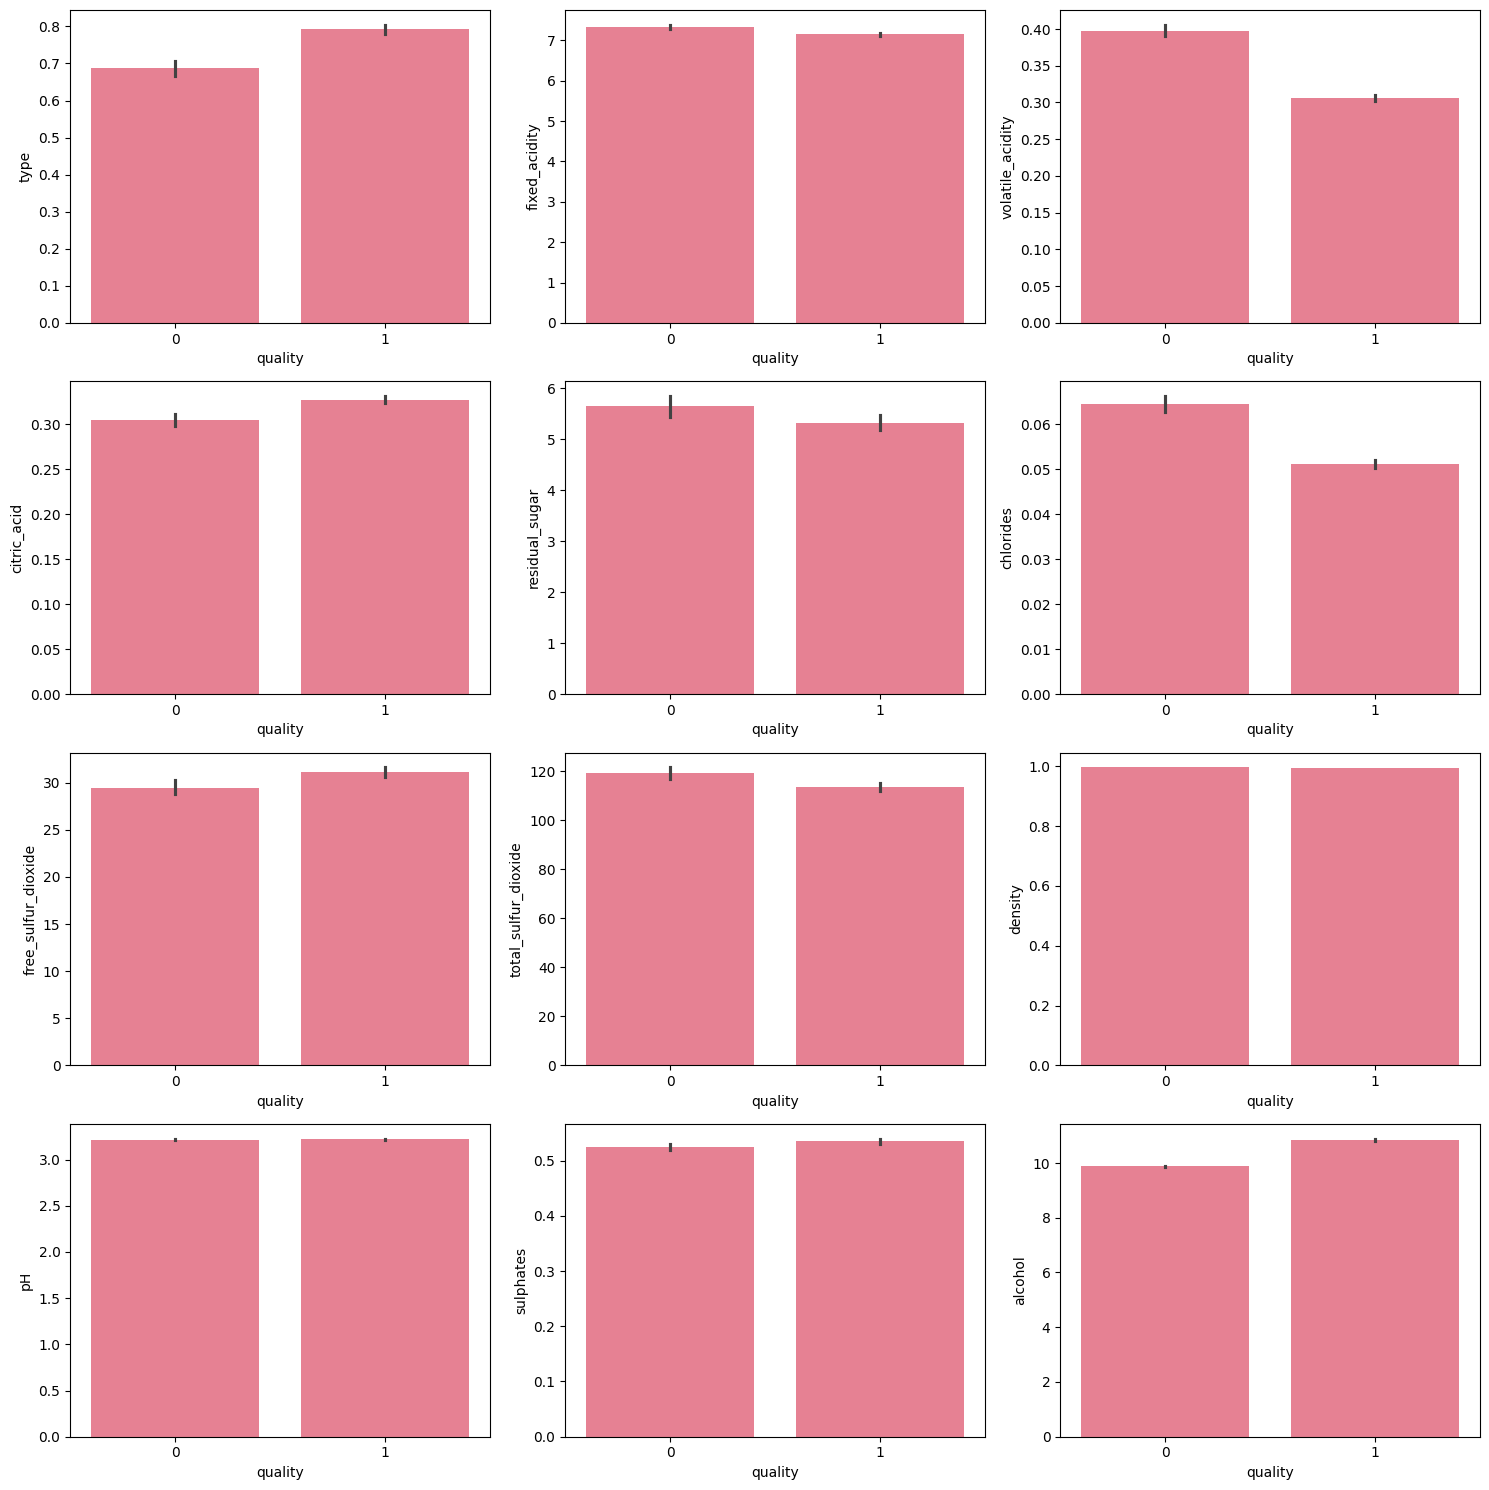

In [127]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

feature_ranges = {}
for i, col in enumerate(wine_df.columns):
    
    if col != 'quality':
        print(i)
        for quality in wine_df['quality'].unique():
            feature_ranges[col + '_' + str(quality)] = [wine_df[wine_df['quality'] == quality][col].min(), wine_df[wine_df['quality'] == quality][col].max()]
            
        sns.barplot(x='quality', y=col, data=wine_df, ax=axs[i//3, i%3])
# remove the empty plot
print(sorted(feature_ranges.items()))
#fig.delaxes(axs[3, 2])
plt.tight_layout()
plt.show()

### Multivariate analysis

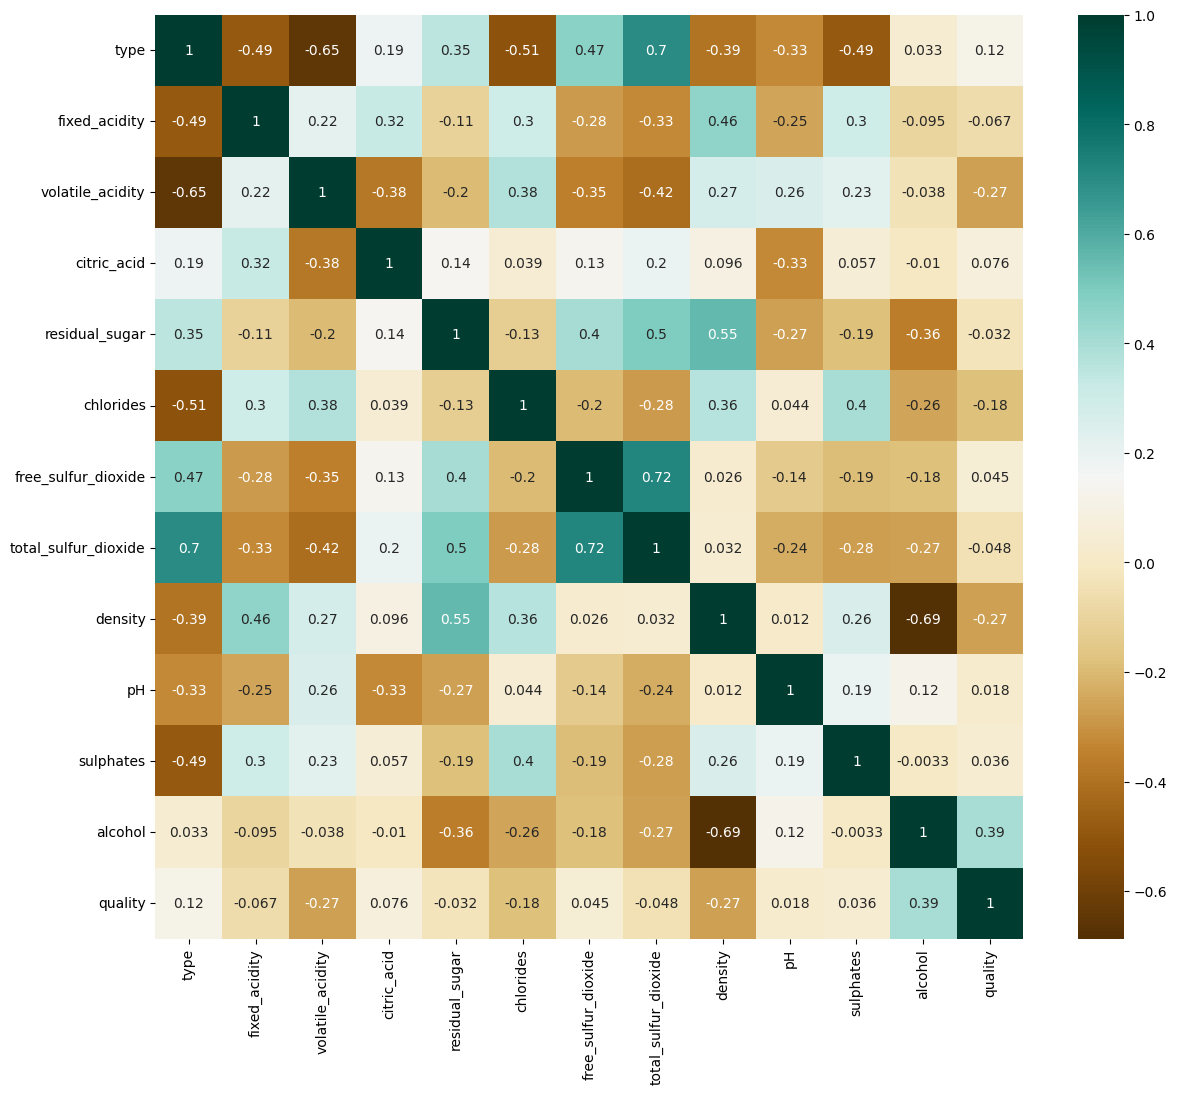

In [128]:
correlation = wine_df.corr()
sns.heatmap(correlation, annot=True, cmap='BrBG').figure.set_size_inches(14, 12)


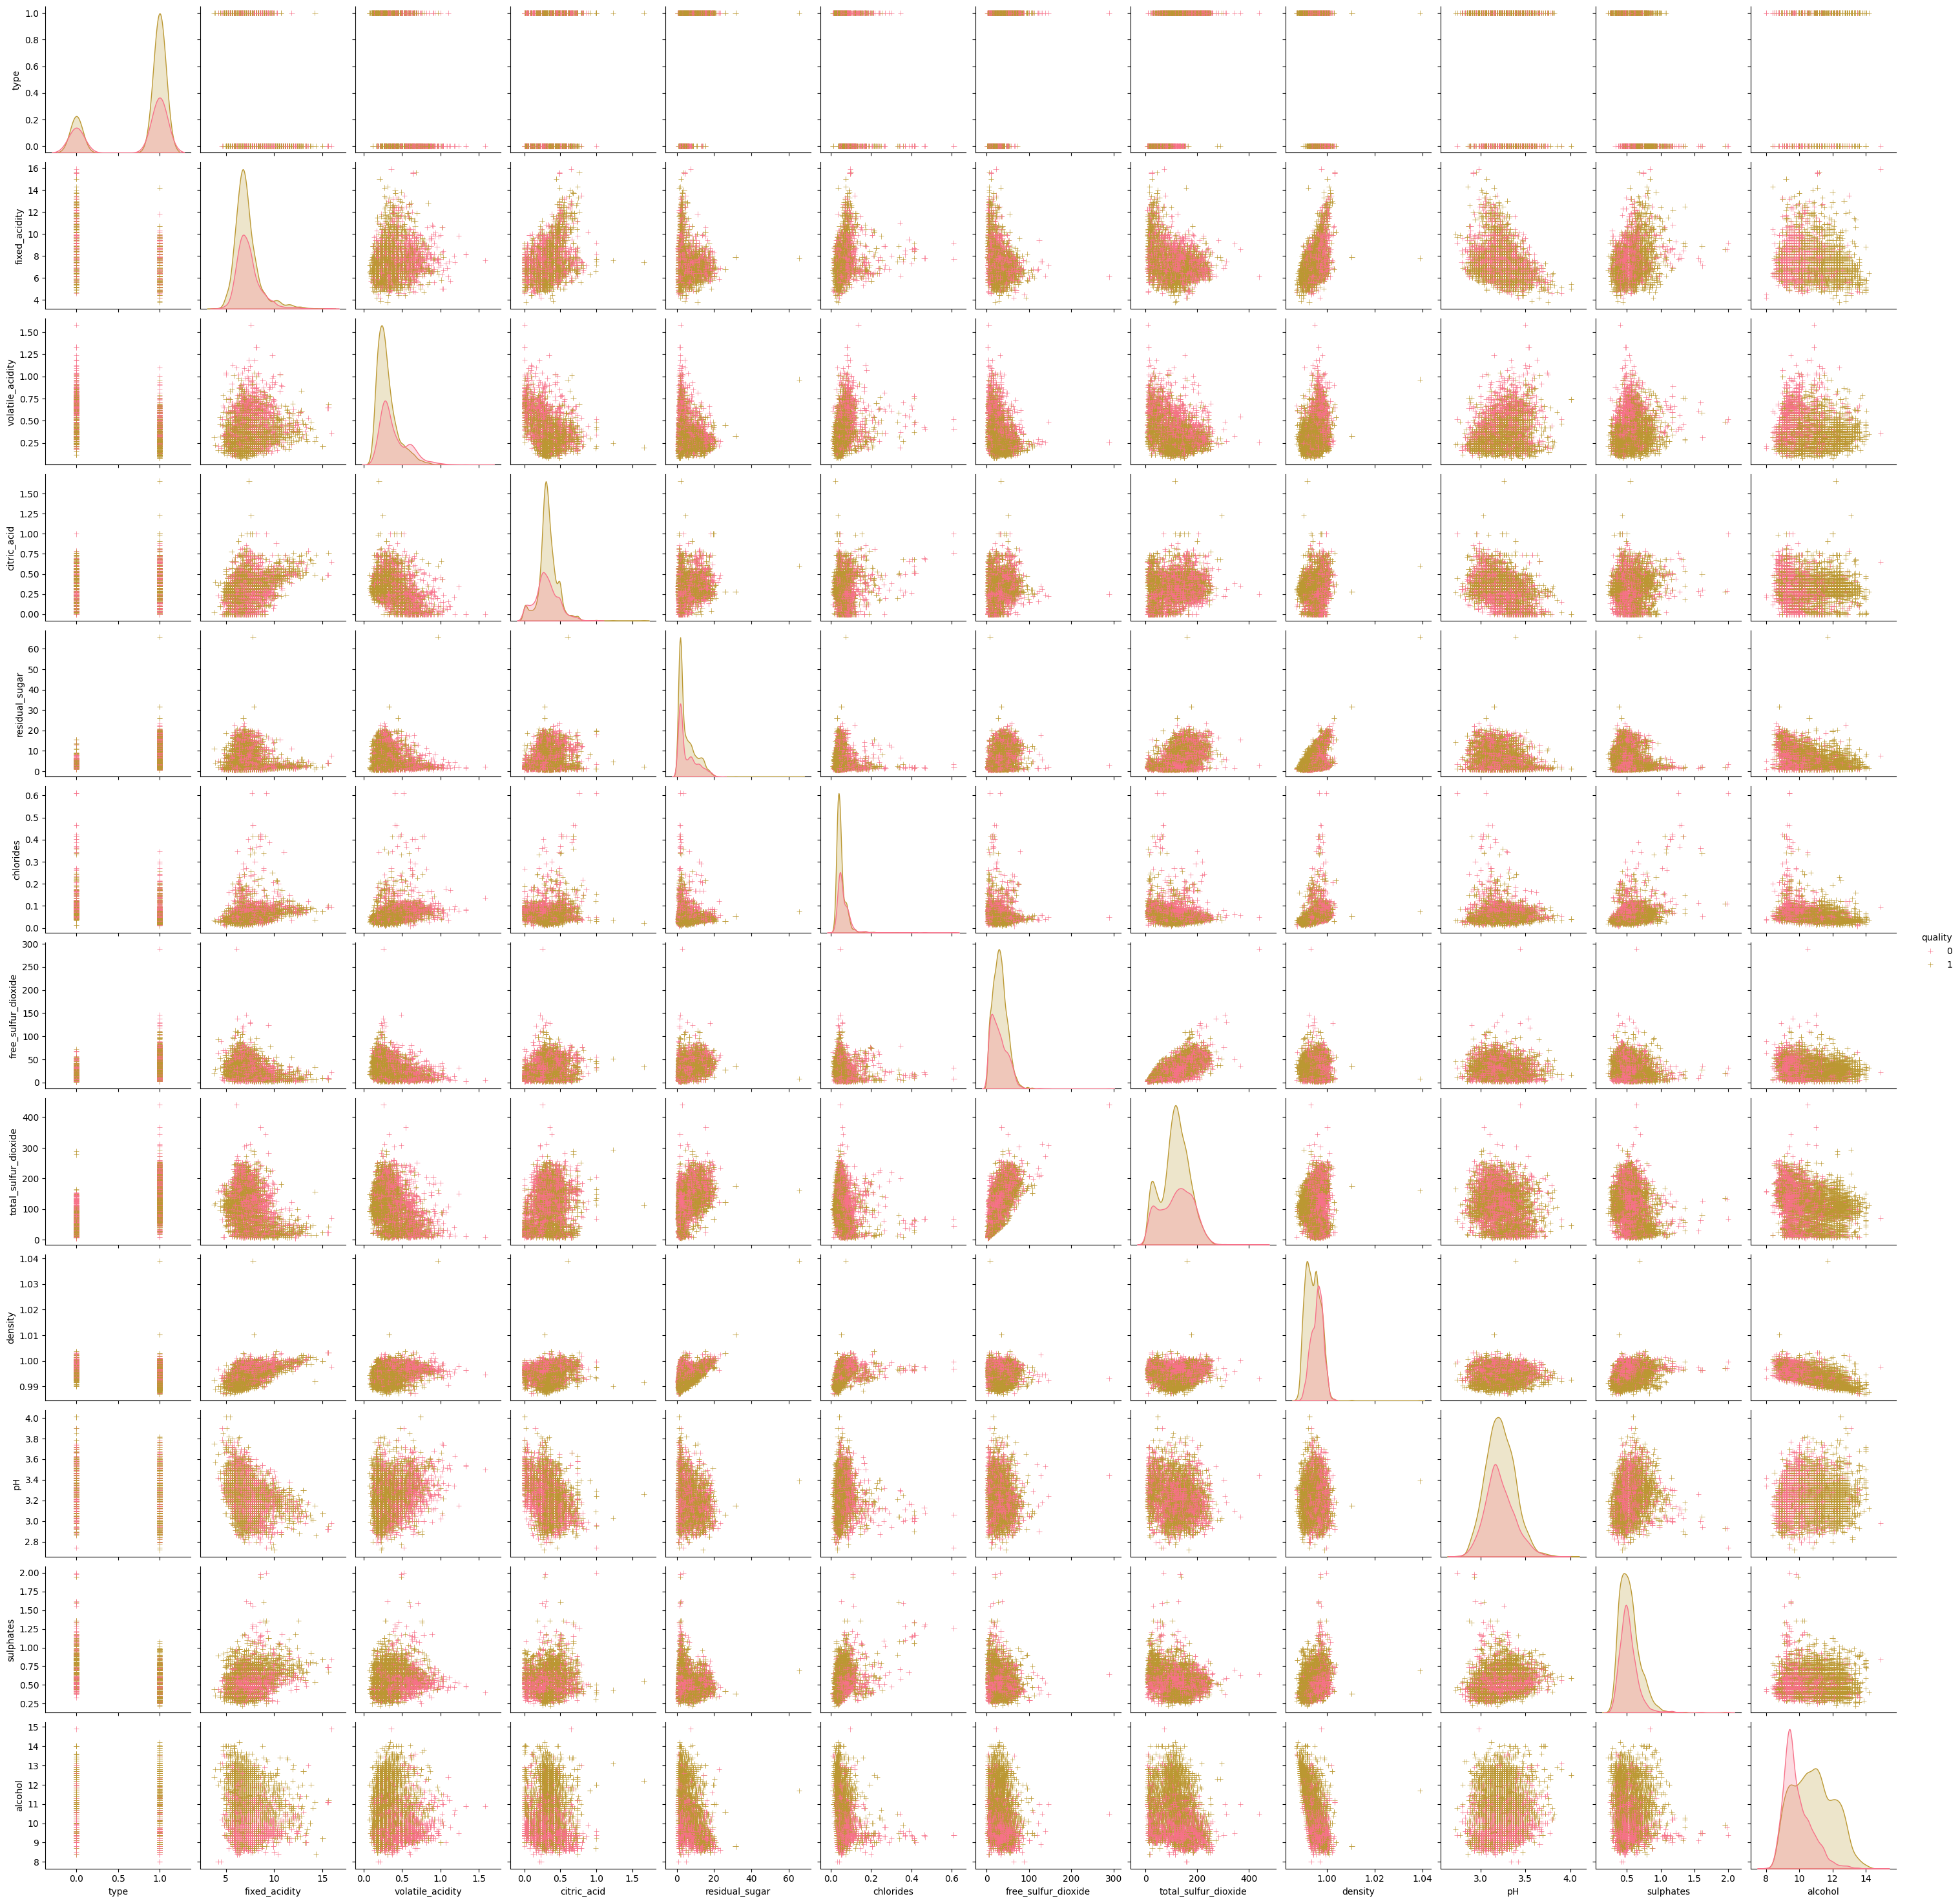

In [129]:
g = sns.pairplot(wine_df, hue='quality', markers='+')
plt.show()

### Drop Features with lower than 0.1 correlation to quality according to Correlation Matrix


In [130]:
# List of columns to be dropped
columns_to_drop = ['fixed_acidity', 'citric_acid', 'residual_sugar', 'total_sulfur_dioxide','free_sulfur_dioxide','pH','sulphates']

# Dropping columns from wine_df
wine_df.drop(columns=columns_to_drop, inplace=True)

In [131]:
wine_df

,type,volatile_acidity,chlorides,density,alcohol,quality
0,1,0.270,0.045,1.00100,8.8,1
1,1,0.300,0.049,0.99400,9.5,1
2,1,0.280,0.050,0.99510,10.1,1
3,1,0.230,0.058,0.99560,9.9,1
4,1,0.230,0.058,0.99560,9.9,1
...,...,...,...,...,...,...
6492,0,0.600,0.090,0.99490,10.5,0
6493,0,0.550,0.062,0.99512,11.2,1
6494,0,0.510,0.076,0.99574,11.0,1
6495,0,0.645,0.075,0.99547,10.2,0


### Insert our Wine DataFrame into a FeatureGroup


In [132]:
wine_fg = fs.get_or_create_feature_group(
     name="wine",
     version=1,
     primary_key=["type","volatile_acidity","chlorides","density","alcohol"], 
     description="wine dataset")
wine_fg.insert(wine_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/194714/fs/194633/fg/225623


Uploading Dataframe: 100.00% |██████████| Rows 6497/6497 | Elapsed Time: 00:04 | Remaining Time: 00:00


Launching job: wine_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/194714/jobs/named/wine_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fa5209921a0>, None)

### Data Validation
If you want, you can enable data validation for your feature group.
The code below will prevent iris flower data from being written your your feature group if you write values outside the expected ranges.

In [16]:
# from great_expectations.core import ExpectationSuite, ExpectationConfiguration

# def expect(suite, column, min_val, max_val):
#     suite.add_expectation(
#     ExpectationConfiguration(
#         expectation_type="expect_column_values_to_be_between",
#         kwargs={
#             "column":column, 
#             "min_value":min_val,
#             "max_value":max_val,
#         }
#     )
# )

In [36]:
# suite = ExpectationSuite(expectation_suite_name="iris_dimensions")

# expect(suite, "sepal_length", 4.5, 8.0)
# expect(suite, "sepal_width", 2.1, 4.5)
# expect(suite, "petal_length", 1.2, 7)
# expect(suite, "petal_width", 0.2, 2.5)
# iris_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT")    